In [1]:
import csv
import random
import pandas as pd
import numpy as np
import random
import scipy
from scipy import stats
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,5) # code pour ajuster les dimensions des images
import seaborn as sns;
import sklearn
from sklearn.datasets import fetch_lfw_people, make_blobs, make_circles, load_digits
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC         #Support vector classifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from IPython.display import Image
from mpl_toolkits import mplot3d
from ipywidgets import interact, fixed

In [2]:
# Charger le fichier Excel en tant que DataFrame pandas en remplaçant tous les '.' par des NaN
data = pd.read_excel('PierreBriacMétayerMariotti_données_psy3019-H23_20230321_Park_PPMI_FreeSurfer_Desikan.xlsx', header=0, na_values='.')

In [3]:
data.head(5)

,PATNO,EVENT_ID,age,gen,EDUCYRS,race,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,rigidity,tau,medulla_Brainstem_x,pons_Brainstem_x,midbrain_Brainstem_x,wholeBrainstem_Brainstem_x,wholeHippocampus_HIPL_x,wholeHippocampus_HIPR_x
0,3000,BL,69.1397,2,18,1,NaN,NaN,NaN,NaN,NaN,1,0.0,213.40,4063.691825,14046.810355,5776.143637,24138.181031,2895.908527,3519.044379
1,3001,BL,65.1425,1,16,1,1.0,1.0,1.0,0.0,0.0,0,2.0,158.60,4974.933261,18332.639036,6910.158509,30503.435945,3701.228126,4057.012720
2,3002,BL,67.5781,2,16,1,1.0,0.0,1.0,0.0,1.0,0,0.0,302.90,4301.061154,13681.058549,5761.421708,24041.676776,2816.082459,3029.247680
3,3003,BL,56.7178,2,16,1,0.0,1.0,1.0,1.0,1.0,0,7.0,110.20,5164.080842,14872.535542,5776.562947,26154.031594,3531.547256,4022.945876
4,3004,BL,59.4137,1,16,1,NaN,NaN,NaN,NaN,NaN,1,0.0,95.88,4983.531846,17554.589658,6287.222189,29084.602621,3311.719011,3461.108583


PATNO = identifiant du patient

EVENT_ID = plusieurs points temporels longitudinaux. Vous pouvez en prendre un seul, ou faire une analyse entre plusieurs pour le même identifiant patient

UPDRS = une échelle pour les patients atteints de Parkinson avec plusieurs variables.

NPI - données multiples pour les variables neuropsychiatriques.

HIP - volumes du tronc cérébral et de l'hippocampe, extraits avec FreeSurfer

HIPL = hippocampe gauche

In [4]:
data.columns

Index(['PATNO', 'EVENT_ID', 'age', 'gen', 'EDUCYRS', 'race', 'symptom1',
       'symptom2', 'symptom3', 'symptom4', 'symptom5', 'symptom6', 'rigidity',
       'tau', 'medulla_Brainstem_x', 'pons_Brainstem_x',
       'midbrain_Brainstem_x', 'wholeBrainstem_Brainstem_x',
       'wholeHippocampus_HIPL_x', 'wholeHippocampus_HIPR_x'],
      dtype='object')

<div class="alert alert-success"> 

Travail 3:

- code pour « def » implémenté (3 %)

- code « Seaborn » implémenté (2 %)

- code LDA implémenté (2 %)

- code SVM implémenté (2 %)

- code KNN implémenté (2 %)

- code RF implémenté (2 %)

- code PCA implémenté (2 %)

## Visualisation des données manquantes

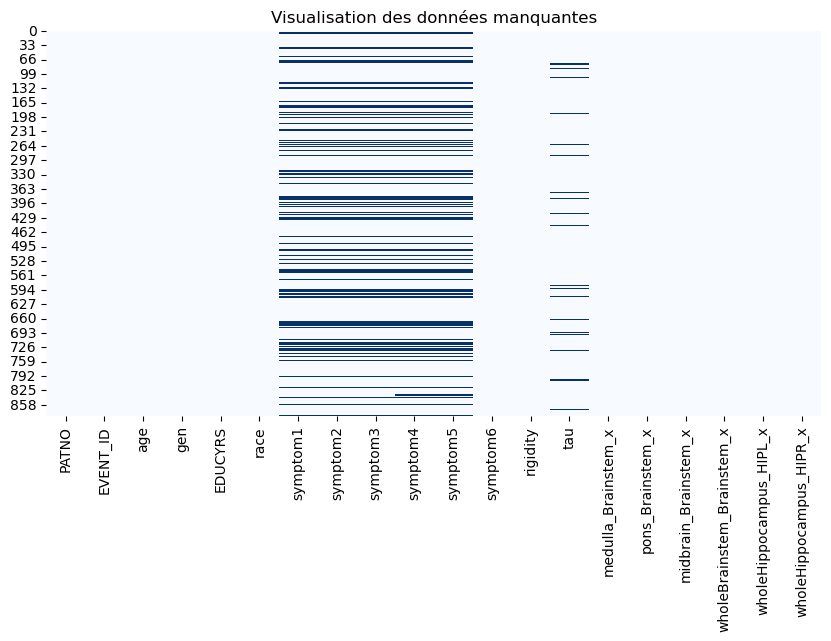

In [5]:
# Graphique des données manquantes
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data.isnull(), cbar=False, cmap='Blues', ax=ax)
plt.title('Visualisation des données manquantes')
plt.show()

In [6]:
# Calculer le pourcentage de valeurs manquantes pour chaque variable du dataset
missing_values = data.isna().mean() * 100 

# Créer un DataFrame pour stocker les pourcentages de valeurs manquantes et les noms des variables correspondantes
df_missing_values = pd.DataFrame({'Variable': missing_values.index, 'Pourcentage de valeurs manquantes': missing_values.values})

# Trier les valeurs par ordre décroissant de pourcentage de valeurs manquantes et réinitialiser les index
df_missing_values = df_missing_values.sort_values(by='Pourcentage de valeurs manquantes', ascending=False).reset_index(drop=True)

# Afficher le DataFrame contenant les pourcentages de valeurs manquantes pour chaque variable
print(df_missing_values)


                      Variable  Pourcentage de valeurs manquantes
0                     symptom5                          23.669309
1                     symptom4                          23.669309
2                     symptom1                          23.216308
3                     symptom2                          23.216308
4                     symptom3                          23.216308
5                          tau                           4.643262
6                     rigidity                           0.113250
7      wholeHippocampus_HIPL_x                           0.000000
8   wholeBrainstem_Brainstem_x                           0.000000
9         midbrain_Brainstem_x                           0.000000
10            pons_Brainstem_x                           0.000000
11         medulla_Brainstem_x                           0.000000
12                       PATNO                           0.000000
13                    symptom6                           0.000000
14        

Nous avons plus de 5% de données manquantes pour les symptom alors on les enlève des analyses

In [7]:
def drop_missing_cols(df, threshold=0.05):
    """
    Supprime les colonnes qui ont plus de 'threshold' de données manquantes dans un dataframe.
    Le seuil par défaut est de 5%.
    """
    # Calculer le nombre de valeurs manquantes dans chaque colonne
    missing_values = df.isna().sum()

    # Calculer le pourcentage de valeurs manquantes dans chaque colonne
    missing_percentages = missing_values / len(df)

    # Trouver les colonnes qui ont un pourcentage de valeurs manquantes supérieur au seuil
    cols_to_drop = list(missing_percentages[missing_percentages > threshold].index)

    # Supprimer les colonnes du dataframe
    df.drop(columns=cols_to_drop, inplace=True)

    # Afficher le nombre de colonnes supprimées
    print(f"{len(cols_to_drop)} colonne(s) ont été supprimée(s).")

    return df

In [8]:
# Supprimer les colonnes avec plus de 5% de données manquantes
data = drop_missing_cols(data, threshold=0.05)

5 colonne(s) ont été supprimée(s).


In [9]:
# Montre le type de données de chaque colonne
print(data.dtypes)

PATNO                           int64
EVENT_ID                       object
age                           float64
gen                            object
EDUCYRS                         int64
race                            int64
symptom6                        int64
rigidity                      float64
tau                           float64
medulla_Brainstem_x            object
pons_Brainstem_x               object
midbrain_Brainstem_x           object
wholeBrainstem_Brainstem_x     object
wholeHippocampus_HIPL_x       float64
wholeHippocampus_HIPR_x       float64
dtype: object


In [10]:
# Convertir la colonne 'medulla_Brainstem_x' en données numériques
data["medulla_Brainstem_x"] = pd.to_numeric(data["medulla_Brainstem_x"], errors='coerce')

# Supprimer les lignes avec des valeurs manquantes dans la colonne 'medulla_Brainstem_x'
data.dropna(subset=["medulla_Brainstem_x"], inplace=True)

# Convertir la colonne 'medulla_Brainstem_x' en données de type float
data["medulla_Brainstem_x"] = data["medulla_Brainstem_x"].astype(float)

# Convertir la colonne 'pons_Brainstem_x' en données de type float
data["pons_Brainstem_x"] = data["pons_Brainstem_x"].astype(float)

# Convertir la colonne 'midbrain_Brainstem_x' en données de type float
data["midbrain_Brainstem_x"] = data["midbrain_Brainstem_x"].astype(float)

# Convertir la colonne 'wholeBrainstem_Brainstem_x' en données de type float
data["wholeBrainstem_Brainstem_x"] = data["wholeBrainstem_Brainstem_x"].astype(float)

In [11]:
print(data.dtypes)

PATNO                           int64
EVENT_ID                       object
age                           float64
gen                            object
EDUCYRS                         int64
race                            int64
symptom6                        int64
rigidity                      float64
tau                           float64
medulla_Brainstem_x           float64
pons_Brainstem_x              float64
midbrain_Brainstem_x          float64
wholeBrainstem_Brainstem_x    float64
wholeHippocampus_HIPL_x       float64
wholeHippocampus_HIPR_x       float64
dtype: object


In [12]:
# Statistiques descriptives des données
data.describe()

,PATNO,age,EDUCYRS,race,symptom6,rigidity,tau,medulla_Brainstem_x,pons_Brainstem_x,midbrain_Brainstem_x,wholeBrainstem_Brainstem_x,wholeHippocampus_HIPL_x,wholeHippocampus_HIPR_x
count,756.000000,756.000000,756.000000,756.000000,756.000000,755.00000,723.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,3569.759259,60.974306,15.468254,1.133598,0.250000,2.80000,173.745297,4616.564733,15650.111778,6343.082404,26892.164833,3503.610441,3583.820177
std,342.245197,10.382685,3.164421,0.558506,0.433299,2.87512,62.908239,615.611295,1897.013441,691.778665,3011.074577,395.491191,386.807312
min,3000.000000,30.615800,5.000000,1.000000,0.000000,0.00000,83.930000,1774.535521,8853.456510,3874.883074,15956.314139,2466.089058,2429.872695
25%,3261.500000,54.038300,14.000000,1.000000,0.000000,0.00000,129.000000,4276.387665,14226.643572,5863.838750,24553.832024,3236.811710,3307.406749
50%,3571.000000,61.917200,16.000000,1.000000,0.000000,2.00000,157.900000,4637.299562,15666.786218,6332.452748,26871.727939,3489.183283,3561.643162
75%,3855.000000,69.029750,18.000000,1.000000,0.250000,4.00000,202.850000,5003.549401,17010.519184,6791.151471,29006.542857,3753.037736,3836.399459
max,4139.000000,84.884000,26.000000,4.000000,1.000000,13.00000,580.800000,6362.775374,22049.763842,8653.338230,37155.225652,4911.466686,4770.707458


<div class="alert alert-info">
<b><h1>LDA (apprentissage supervisé)</h1></b></div>

In [13]:
# Créer un nouveau DataFrame qui contient seulement les colonnes d'intérêt
data_LDA = data.loc[:, ['tau', 'medulla_Brainstem_x', 'pons_Brainstem_x', 'midbrain_Brainstem_x', 'wholeBrainstem_Brainstem_x', 'wholeHippocampus_HIPL_x', 'wholeHippocampus_HIPR_x', 'rigidity']]

# Supprimer les lignes avec des valeurs manquantes dans le nouveau DataFrame
data_LDA.dropna(inplace=True)

In [14]:
# Sélectionner les colonnes d'intérêt pour les données d'entrée et de sortie
X = data_LDA[['tau', 'medulla_Brainstem_x', 'pons_Brainstem_x', 'midbrain_Brainstem_x', 'wholeBrainstem_Brainstem_x', 'wholeHippocampus_HIPL_x', 'wholeHippocampus_HIPR_x']]
Y = data_LDA['rigidity']

# Encoder les étiquettes de sortie en utilisant LabelEncoder
enc = LabelEncoder()
label_encoder = enc.fit(Y)
Y = label_encoder.transform(Y) + 1

# Effectuer LDA sur les données d'entrée et de sortie
sklearn_lda = LDA(n_components=2)
X_lda_sklearn_p = sklearn_lda.fit_transform(X, Y)

# Faire des prédictions sur les données d'entrée et afficher le rapport de classification
pred = sklearn_lda.predict(X)
print(classification_report(Y, pred))

              precision    recall  f1-score   support

           1       0.31      0.90      0.46       215
           2       0.25      0.01      0.02        87
           3       0.75      0.03      0.07        87
           4       0.20      0.17      0.18        82
           5       0.00      0.00      0.00        74
           6       0.00      0.00      0.00        52
           7       0.00      0.00      0.00        36
           8       0.00      0.00      0.00        36
           9       0.33      0.05      0.08        21
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00        17
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         2

    accuracy                           0.29       722
   macro avg       0.13      0.08      0.06       722
weighted avg       0.24      0.29      0.17       722



/Users/pierre-briacmetayer/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierre-briacmetayer/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierre-briacmetayer/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

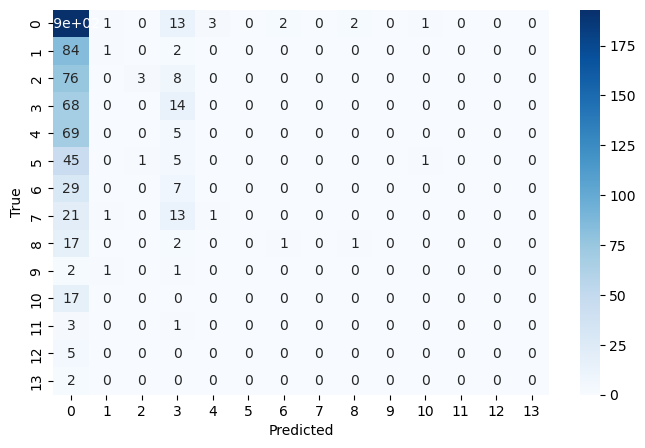

In [15]:
# Créer une matrice de confusion à partir des prédictions et des étiquettes de sortie
cm = confusion_matrix(Y, pred)

# Afficher la matrice de confusion sous forme de heatmap
sns.heatmap(cm, annot=True, cmap="Blues")

# Ajouter des étiquettes pour les axes x et y
plt.xlabel('Predicted')
plt.ylabel('True')

# Afficher le graphique
plt.show()

<div class="alert alert-info">
<b><h1>SVM (machines à vecteurs de support)</h1></b></div>

In [16]:
data_SVM = data.loc[:, ['age', 'medulla_Brainstem_x', 'pons_Brainstem_x', 'midbrain_Brainstem_x', 'wholeBrainstem_Brainstem_x', 'wholeHippocampus_HIPL_x', 'wholeHippocampus_HIPR_x', 'rigidity']]
data_SVM.dropna(inplace=True)

In [17]:
# Définition d'une fonction qui effectue une classification binaire en fonction d'une valeur seuil

def classification(data, name, valeur):
    liste = []
    for i in data[name]:
        if i >= valeur :
            liste.append(1)
        else :
            liste.append(0)
    return liste

In [18]:
data_SVM['Categorie_Age'] = classification(data_SVM, 'age', 60)

In [19]:
# Sélectionner les colonnes d'intérêt pour les données d'entrée et de sortie
X = data_SVM[['medulla_Brainstem_x', 'pons_Brainstem_x', 'midbrain_Brainstem_x', 'wholeBrainstem_Brainstem_x', 'wholeHippocampus_HIPL_x', 'wholeHippocampus_HIPR_x', 'rigidity']]
Y = data_SVM['Categorie_Age']

# Encoder les étiquettes de sortie en utilisant LabelEncoder
enc = LabelEncoder()
label_encoder = enc.fit(Y)
Y = label_encoder.transform(Y) + 1

# Créer un classifieur SVM avec un noyau RBF
clf = SVC(kernel='rbf', C=1E6)

# Entrainer le classifieur sur les données d'entrée et de sortie
clf.fit(X, Y)

SVC(C=1000000.0)

In [20]:
from sklearn.model_selection import cross_val_score

# Effectuez une normalisation ou une standardisation des données si nécessaire
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Effectuez une validation croisée à 5 plis
scores = cross_val_score(clf, X, Y, cv=5)

# Affichez la précision moyenne sur les 5 plis
print("Précision moyenne: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Précision moyenne: 0.52 (+/- 0.08)


La performance du modèle est assez stable, car l'écart-type est relativement faible, mais la précision est modérée, ce qui suggère que le modèle peut être amélioré.

<div class="alert alert-info">
<b><h1>KNN </h1></b>
    

L'algorithme KNN est un classificateur robuste et polyvalent qui est souvent utilisé comme référence pour des classificateurs plus complexes tels que les réseaux de neurones artificiels (ANN) et les machines à vecteurs de support (SVM)
</div>

In [21]:
data_KNN = data_SVM

In [22]:
# Créer la matrice de design X et le vecteur de cible y
X = data_KNN[['medulla_Brainstem_x', 'pons_Brainstem_x', 'midbrain_Brainstem_x', 'wholeBrainstem_Brainstem_x', 'wholeHippocampus_HIPL_x', 'wholeHippocampus_HIPR_x', 'rigidity']]
Y = data_KNN['Categorie_Age']

# Séparer les données en ensembles d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

# Instancier le modèle d'apprentissage (k = 3)
model = KNN(n_neighbors=3)

# Entraîner le modèle
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
pred = model.predict(X_test)

# Évaluer l'exactitude (accuracy) du modèle
print(accuracy_score(y_test, pred))

0.668


<div class="alert alert-info">
<b><h1>Forêts Aléatoires </h1></b>
</div>

In [23]:
data_FA = data_KNN

In [24]:
X = data_FA[['rigidity','medulla_Brainstem_x', 'pons_Brainstem_x', 'midbrain_Brainstem_x', 'wholeBrainstem_Brainstem_x', 'wholeHippocampus_HIPL_x', 'wholeHippocampus_HIPR_x']]
Y = data_FA['Categorie_Age']

In [25]:
# Divisez la base de données en ensembles de formation et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)

# Créez une instance de l'estimateur RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, random_state=1)

# Ajustez le modèle sur l'ensemble de formation
rfc.fit(X_train, y_train)

# Prédisez les étiquettes de classe sur l'ensemble de test
y_pred = rfc.predict(X_test)

# Évaluez les performances du modèle à l'aide d'une métrique de classification
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.69      0.71        75
           1       0.80      0.82      0.81       114

    accuracy                           0.77       189
   macro avg       0.76      0.76      0.76       189
weighted avg       0.77      0.77      0.77       189



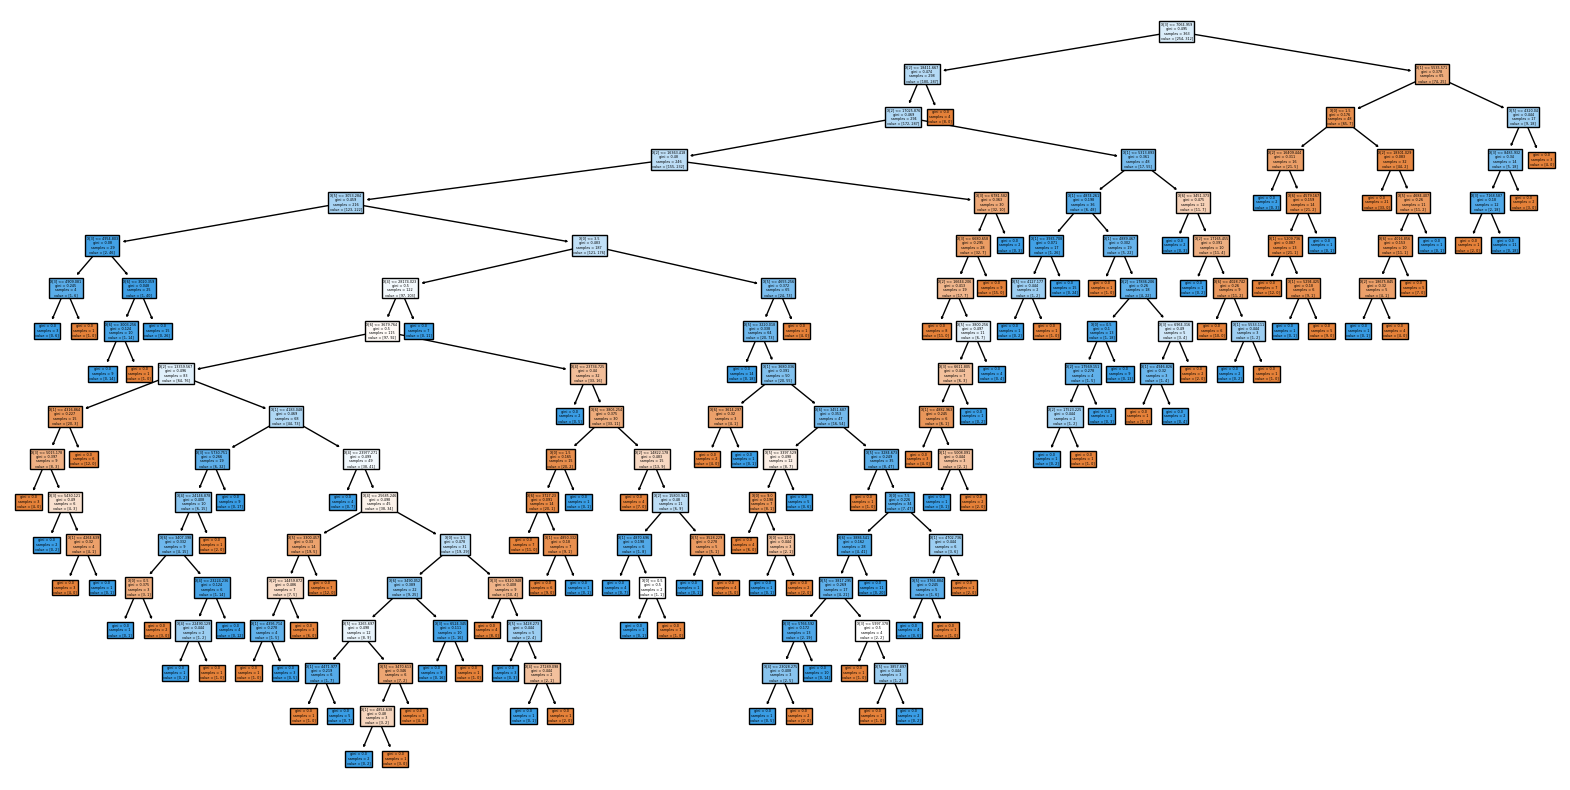

In [26]:
# Créer une figure avec une taille de 20 pouces par 10 pouces
plt.figure(figsize=(20,10))

# Afficher l'arbre de décision à l'aide de la fonction plot_tree() de scikit-learn
# rfc.estimators_[0] sélectionne le premier arbre de décision de la forêt aléatoire
# L'argument filled=True permet de remplir les noeuds de l'arbre avec des couleurs en fonction de la classe majoritaire
plot_tree(rfc.estimators_[0], filled=True)

# Afficher la figure
plt.show()

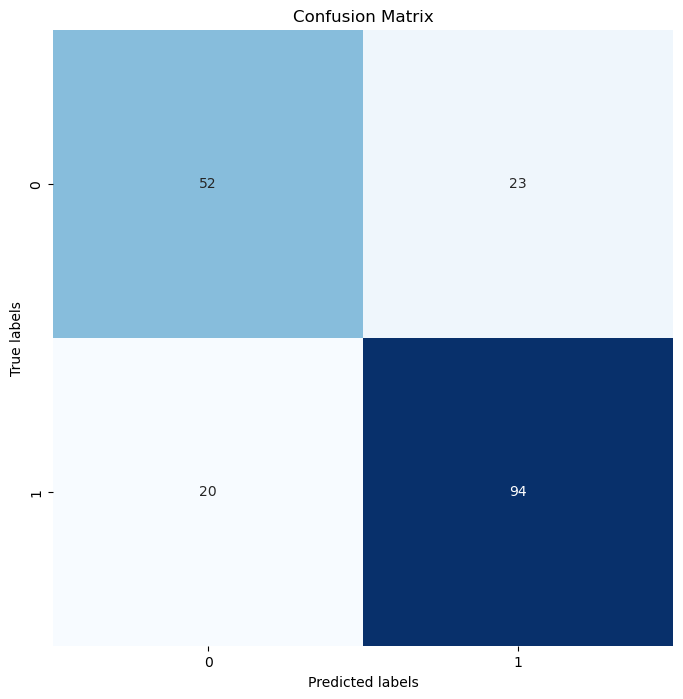

In [27]:
# Obtenez la matrice de confusion pour les prédictions sur l'ensemble de test
cm = confusion_matrix(y_test, y_pred)

# Créez une figure et un axe pour la matrice de confusion
fig, ax = plt.subplots(figsize=(8, 8))

# Tracez la matrice de confusion en utilisant la bibliothèque seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, ax=ax)

# Ajoutez des étiquettes aux axes x et y
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

# Ajoutez un titre à la figure
ax.set_title('Confusion Matrix')

# Affichez la figure
plt.show()

<div class="alert alert-info">
<b><h1>PCA (analyse en composante principale) </h1></b>
</div>

In [28]:
data_PCA = data_KNN

In [29]:
def perform_pca(data, target_col):
    X = data.drop([target_col], axis=1)
    Y = data[target_col]
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    X_pca = np.column_stack((X_pca, Y))
    data_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', target_col])
    return data_pca, pca

def plot_pca(data_pca, pca):
    sns.scatterplot(data=data_pca, x='PC1', y='PC2', hue=data_pca.columns[-1], palette='plasma')
    plt.xlabel('PC1 ({}%)'.format(round(100*pca.explained_variance_ratio_[0], 2)))
    plt.ylabel('PC2 ({}%)'.format(round(100*pca.explained_variance_ratio_[1], 2)))
    plt.title('PCA Plot')
    plt.show()

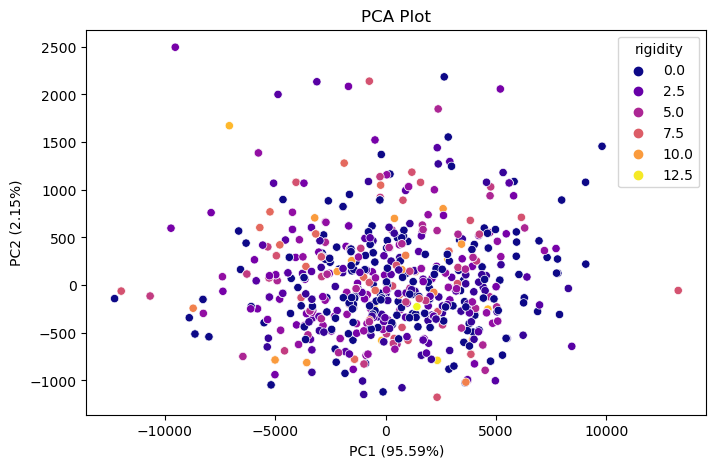

In [30]:
# appel de la fonction perform_pca
target_col = 'rigidity'
data_pca, pca = perform_pca(data_PCA, target_col)
# appel de la fonction plot_pca
plot_pca(data_pca, pca)